In [42]:
import pandas as pd
uselog=pd.read_csv('use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [43]:
customer = pd.read_csv('customer_join.csv')
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


In [44]:
customer_clustering  = customer_join[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans=KMeans(n_clusters=4,random_state=0)
clusters=kmeans.fit(customer_clustering_sc)
customer_clustering=customer_clustering.assign(cluster=clusters.labels_)

print(customer_clustering['cluster'].unique())
customer_clustering.head()

[1 2 3 0]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


In [46]:
customer_clustering.groupby('cluster').mean()

,mean,median,max,min,membership_period
cluster,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868


In [47]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca=pca.transform(X)
pca_df=pd.DataFrame(x_pca)
pca_df['cluster']=customer_clustering['cluster']

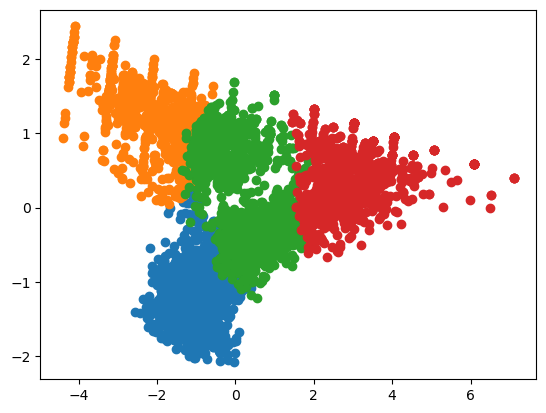

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering['cluster'].unique():
    tmp=pca_df.loc[pca_df['cluster']==i]
    plt.scatter(tmp[0],tmp[1])

In [49]:
customer_clustering=pd.concat([customer_clustering,customer],axis=1)
customer_clustering.groupby(['cluster','is_deleted'],as_index=False).count()[['cluster','is_deleted','customer_id']]

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [50]:
customer_clustering.groupby(['cluster','routine_flg'],as_index=False).count()[['cluster','routine_flg','customer_id']]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,788
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


In [51]:
uselog['usedate']=pd.to_datetime(uselog['usedate'])
uselog['年月']=uselog['usedate'].dt.strftime('%Y%m')
uselog_months=uselog.groupby(['年月','customer_id'],as_index=False).count()
uselog_months.rename(columns={'log_id':'count'},inplace=True)
del uselog_months['usedate']
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [55]:
year_months = list(uselog_months['年月'].unique())
predict_data=pd.DataFrame()
for i in range(6,len(year_months)):
    tmp=uselog_months.loc[uselog_months['年月']==year_months[i]].copy()
    tmp.rename(columns={'count':'count_pred'},inplace=True)
    for j in range(1,7):
        tmp_before=uselog_months.loc[uselog_months['年月']==year_months[i-j]].copy()
        del tmp_before['年月']
        tmp_before.rename(columns={'count':f'count_{j}'},inplace=True)
        tmp=pd.merge(tmp, tmp_before, on='customer_id',how='left' , suffixes=(False, False))
    predict_data=pd.concat([predict_data, tmp],ignore_index=True)
predict_data.head()

,年月,customer_id,count_pred,count_1,count_2,count_3,count_4,count_5,count_6
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [59]:
predict_data=predict_data.dropna()
predict_data=predict_data.reset_index(drop=True)
predict_data

,年月,customer_id,count_pred,count_1,count_2,count_3,count_4,count_5,count_6,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01
...,...,...,...,...,...,...,...,...,...,...
15108,201903,TS995299,3,3.0,5.0,4.0,5.0,4.0,5.0,2015-09-01
15109,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0,2018-09-01
15110,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0,2016-06-01
15111,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0,2017-03-01


In [58]:
predict_data = pd.merge(predict_data,customer[['customer_id','start_date']],on='customer_id',how='left')
predict_data.head()

,年月,customer_id,count_pred,count_1,count_2,count_3,count_4,count_5,count_6,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [61]:
predict_data['now_date']=pd.to_datetime(predict_data['年月'],format='%Y%m')
predict_data['start_date']=pd.to_datetime(predict_data['start_date'])
from dateutil.relativedelta import relativedelta
predict_data['period']=None
for i in range(len(predict_data)):
    delta=relativedelta(predict_data.loc[i,'now_date'],predict_data.loc[i,'start_date'])
    predict_data.loc[i,'period']=delta.years*12 + delta.months
predict_data.head()

,年月,customer_id,count_pred,count_1,count_2,count_3,count_4,count_5,count_6,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


In [69]:
predict_data=predict_data.loc[predict_data['start_date']>=pd.to_datetime('20180401')]
from sklearn import linear_model
import sklearn.model_selection
model=linear_model.LinearRegression()
X=predict_data[['count_1','count_2','count_3','count_4','count_5','count_6','period']]
y=predict_data['count_pred']
X_train,X_test,y_train,y_test=sklearn.model_selection.train_test_split(X,y,random_state=0)
model.fit(X_train,y_train)

LinearRegression()

In [70]:
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.6111525903215709
0.5964633323568842


In [71]:
coef = pd.DataFrame({'feature_name':X.columns,'coefficient':model.coef_})
coef

,feature_name,coefficient
0,count_1,0.359133
1,count_2,0.181937
2,count_3,0.151177
3,count_4,0.184593
4,count_5,0.076946
5,count_6,0.058731
6,period,0.047007


In [73]:
x1=[3,4,4,6,8,7,8]
x2=[2,2,3,3,4,6,8]
x_pred=pd.DataFrame(data=[x1,x2],columns=['count_1','count_2','count_3','count_4','count_5','count_6','period'])

In [74]:
model.predict(x_pred)

array([3.77011036, 1.97563148])

In [75]:
uselog_months.to_csv('use_log_months',index=False)